# image classification with PyTorch

## import libraries

In [1]:
# . . import libraries
import os
from pathlib import Path
# . . pytorch modules
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# . . numpy
import numpy as np
# . . scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# . . matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as npimg
# . .  set this to be able to see the figure axis labels in a dark theme
from matplotlib import style
#style.use('dark_background')
# . . to see the available options
# print(plt.style.available)

from torchsummary import summary

# . . import libraries by tugrulkonuk
import utils
#from dataset import Dataset
from model import *
from trainer import Trainer
from callbacks import ReturnBestModel, EarlyStopping


# set device and precision

In [2]:
# . . set the device
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = torch.device("cpu")      
# . . set the default tensor to cuda: DO NOT USE THIS
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True

torch.backends.cudnn.enabled = True

In [3]:
# . . arguments . .
# . . this is only for the Jupyter notebook as there is no command line
class Args():
    # . . number of epochs 
    epochs = 10

    # . . the learning rate 
    lr = 0.001

    # . . batch_size
    batch_size = 1024

    # . . fraction of data to be used in training
    train_size = 0.8

    # . . min delta (min improvement) for early stopping
    min_delta = 0.0005

    # . . patience for early stopping
    patience = 10

    # . . number of workers for the data loader
    num_workers = 8

    # . . use pinn memory for faster CPU-GPU transler
    pin_memory = False

    # . . print interval
    jprint = 1



In [4]:
# . . instantiate the command-line parameters object
args = Args()

# . . get command-line parameters
num_epochs    = args.epochs
batch_size    = args.batch_size
learning_rate = args.lr
train_size    = args.train_size
min_delta     = args.min_delta
patience      = args.patience 
num_workers   = args.num_workers
pin_memory    = args.pin_memory
jprint        = args.jprint

## import the data


In [5]:
# . . transformer for data augmentation
transformer_train = torchvision.transforms.Compose([
  # torchvision.transforms.ColorJitter(
  #     brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  #transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  # torchvision.transforms.RandomRotation(degrees=15),
  torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # torchvision.transforms.RandomPerspective(),
  transforms.ToTensor(),                                            
])

# . . the train set
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

# . . the validation set: no augmentation!
valid_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)


In [6]:
# . . the number of classes in the data
num_classes = 10
print('number of classes: ',num_classes)

number of classes:  10


## data loaders

In [7]:
# . . the training loader: shuffle
trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the test loader: no shuffle
validloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

In [8]:
utils.batchinfo(trainloader, label=True)
utils.batchinfo(validloader, label=True)

------------------
There are 59 batches in the dataset
For one iteration (batch), there are:
Data:    torch.Size([1024, 1, 28, 28])
Label:   torch.Size([1024])
------------------
------------------
There are 10 batches in the dataset
For one iteration (batch), there are:
Data:    torch.Size([1024, 1, 28, 28])
Label:   torch.Size([1024])
------------------


In [9]:
# . . instantiate the model
in_channels = 1
model = BayesianCNNClassifierMNIST(in_channels, num_classes, lrt=False)

# . . send model to device (GPU)
model.to(device)

BayesianCNNClassifierMNIST(
  (conv1): Sequential(
    (0): BayesianConv2d()
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BayesianConv2d()
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BayesianConv2d()
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BayesianConv2d()
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): BayesianConv2d()
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BayesianConv2d()
    (4): ReLU()
    (5): BatchNorm2d(128, eps

# . . show a summary of the model
summary(model, (1, 28, 28))

In [10]:
# . . create the trainer
trainer = Trainer(model, device)

# . . compile the trainer
# . . define the loss
class elbo(nn.Module):
    def __init__(self):
        super(elbo, self).__init__()

    def forward(self, input, target, kl, beta, batch_size):
        assert not target.requires_grad
        return F.nll_loss(input, target, reduction='mean') * batch_size + beta * kl

criterion = elbo().to(device)

# . . define the optimizer
optimparams = {'lr':learning_rate
              }

# . . define the callbacks
cb=[ReturnBestModel(), EarlyStopping(min_delta=min_delta, patience=patience)]

trainer.compile(optimizer='adam', criterion=criterion, callbacks=cb, jprint=jprint, **optimparams)

# . . the learning-rate scheduler
schedulerparams = {'factor':0.5,
                   'patience':50,
                   'threshold':1e-5,
                   'cooldown':5,
                   'min_lr':1e-5,                
                   'verbose':True               
                  }
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, **schedulerparams)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0


In [11]:
# . . train the network
train_loss, valid_loss = trainer.fit(trainloader, validloader, scheduler=None, num_epochs=num_epochs)

Training started:  January 29, 2021 - 10:25AM
Epoch:     0	Train Loss: 57908.1718	Valid Loss: 313306.2963	KLDiv Loss: 181496.9334	Train Accuracy: 0.8385	Valid Accuracy: 0.7586	Elapsed time: 0:00:06.258245
Epoch:     1	Train Loss: 52836.7938	Valid Loss: 294590.2788	KLDiv Loss: 171745.4458	Train Accuracy: 0.9681	Valid Accuracy: 0.9710	Elapsed time: 0:00:05.171788
Epoch:     2	Train Loss: 49797.9613	Valid Loss: 276477.6689	KLDiv Loss: 161331.3955	Train Accuracy: 0.9798	Valid Accuracy: 0.9734	Elapsed time: 0:00:05.189308
Epoch:     3	Train Loss: 46710.2087	Valid Loss: 259228.2047	KLDiv Loss: 151278.1218	Train Accuracy: 0.9856	Valid Accuracy: 0.9739	Elapsed time: 0:00:05.233516
Epoch:     4	Train Loss: 43784.8428	Valid Loss: 243274.3781	KLDiv Loss: 141938.3223	Train Accuracy: 0.9895	Valid Accuracy: 0.9763	Elapsed time: 0:00:05.284747
Epoch:     5	Train Loss: 41093.4954	Valid Loss: 228731.1841	KLDiv Loss: 133403.0741	Train Accuracy: 0.9903	Valid Accuracy: 0.9794	Elapsed time: 0:00:05.259169


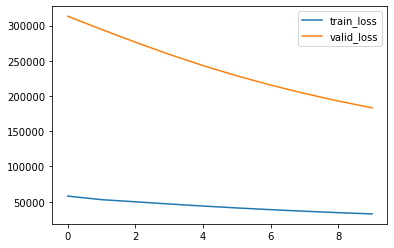

In [12]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'])

In [13]:
eval_batch_size = 32

# . . training dataset without augmentation
train_dataset_noaug = torchvision.datasets.MNIST(
                      root='.',
                      train=True,
                      transform=transforms.ToTensor(),
                      download=True)

# . . data loader for the training dataset without transforms
trainloader_noaug = torch.utils.data.DataLoader(
                     dataset=train_dataset_noaug, 
                     batch_size=eval_batch_size, 
                     shuffle=False,
                     num_workers=num_workers,
                     pin_memory=pin_memory)

In [14]:
training_accuracy, test_accuracy = trainer.evaluate(trainloader_noaug, validloader)

Training accuracy: 0.9930, Test accuracy: 0.9818


The confusion matrix is not normalized
[[ 966    0    2    0    0    2    4    1    4    1]
 [   0 1129    3    0    0    0    1    1    1    0]
 [   1    2 1017    1    1    0    1    6    3    0]
 [   1    0    4  985    0   11    0    4    3    2]
 [   0    1    3    0  957    0    5    3    1   12]
 [   1    0    0    4    0  883    2    1    0    1]
 [   5    2    0    0    1    4  946    0    0    0]
 [   0    1    6    3    3    0    0 1010    2    3]
 [   3    2    5    3    1    3    0    1  950    6]
 [   0    3    1    0   12    2    1   16    5  969]]


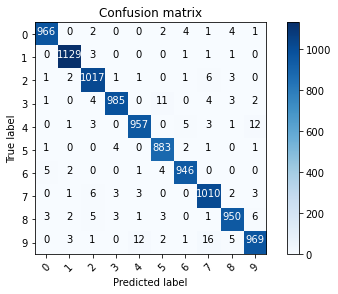

In [15]:
#. . calculate and plot the confusion matrix
x_test = valid_dataset.data
y_test = np.array(valid_dataset.targets)
p_test = np.array([])

num_ensemble = 1
for inputs, targets in validloader:
    # . . move to device
    inputs, targets = inputs.to(device), targets.to(device)

    # . . prepare the outputs for multiple ensembles
    outputs = torch.zeros(inputs.shape[0], trainer.model.num_classes, num_ensemble).to(device)
                
    # . . feed-forward network: multiple ensembles
    kl_div = 0.0                
    for ens in range(num_ensemble):
        outputs_, kl_div_ = trainer.model(inputs)
        # . . accumulate the kl div loss
        kl_div += kl_div_
        # . . keep the outputs
        outputs[:,:,ens] = F.log_softmax(outputs_, dim=1).data

    # . . normalise the kl div loss over ensembles
    kl_div /= num_ensemble

    # . . make sure the outputs are positive
    log_outputs = utils.logmeanexp(outputs, dim=2)
    #log_outputs = torch.mean(outputs, dim=2)

    # . . network predictions
    _, predictions = torch.max(log_outputs, 1)

    # . . update the p-test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

# . . the confusion matrix
cm = confusion_matrix(y_test, p_test)

# . . plot the confusion matrix 
utils.plot_confusion_matrix(cm, list(range(10)))

In [16]:
torch.save(trainer.model.state_dict(), 'models/final_model.pt')